In [1]:
import random
import time

#from matplotlib import cm
#import matplotlib.pyplot as plt
#from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd

#plt.rcParams.update({'font.size': 12})

from simantha import Source, Machine, Buffer, Sink, Repairman, System, utils

In [2]:
def generate_degradation_matrix(p, h_max):
    degradation_matrix = []
    for h in range(h_max):
        transitions = [0] * (h_max + 1)
        transitions[h] = 1 - p
        transitions[h+1] = p
        degradation_matrix.append(transitions)
    degradation_matrix.append([0]*h_max + [1])
    return degradation_matrix

### Simantha Overview

1. Define objects
    - Source
        - Interarrival time
    - Machine
        - Cycle time
        - Degradation
        - Maintenance policy
        - Repair times
    - Buffer
        - Capacity
    - Sink
    - Repairman
        - Capacity
2. Define routing
    - Upstream
    - Downstream
3. Assemble system and simulate

### Single machine
<!--- $\rightarrow M_1 \rightarrow$ -->
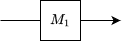

In [2]:
source = Source()
M1 = Machine(name='M1', cycle_time=1)
sink = Sink()

objects = [source, M1, sink]

M1.define_routing(upstream=[source], downstream=[sink])

system = System(objects=[source, M1, sink])

system.simulate(simulation_time=100)

AttributeError: 'Environment' object has no attribute 'event_trace'

### 2 machine 1 buffer line

<!--- $\rightarrow M_1\rightarrow B_1 \rightarrow M_2 \rightarrow$ -->

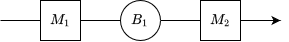

In [3]:
source = Source()
M1 = Machine(name='M1', cycle_time=1)
B1 = Buffer(capacity=10)
M2 = Machine(name='M2', cycle_time=1)
sink = Sink()

objects = [source, M1, B1, M2, sink]

M1.define_routing(upstream=[source], downstream=[B1])
M2.define_routing(upstream=[B1], downstream=[sink])

system = System(objects=objects)

system.simulate(simulation_time=100)

Simulation finished in 0.00s
Parts produced: 99


In [4]:
m1_production = pd.DataFrame(M1.production_data).rename(columns={'production':'M1'})
m2_production = pd.DataFrame(M2.production_data).rename(columns={'production':'M2'})
production = pd.merge(
    m1_production, m2_production, on='time', how='outer'
).fillna(0).astype(int)[['time', 'M1', 'M2']]

production[:10]

,time,M1,M2
0,0,0,0
1,1,1,0
2,2,2,1
3,3,3,2
4,4,4,3
5,5,5,4
6,6,6,5
7,7,7,6
8,8,8,7
9,9,9,8


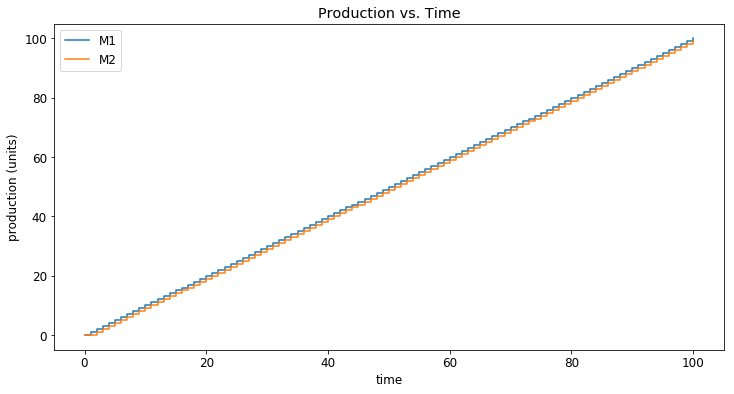

In [6]:
plt.figure(figsize=(12,6))

m1_production = pd.DataFrame(M1.production_data)
m2_production = pd.DataFrame(M2.production_data)

plt.step(production['time'], production['M1'], where='post', label='M1')
plt.step(production['time'], production['M2'], where='post', label='M2')

plt.title('Production vs. Time')
plt.xlabel('time')
plt.ylabel('production (units)')

plt.legend()

plt.show()

### 2 machine parallel line
<!--- $\rightarrow [M_1, M_2] \rightarrow$ -->

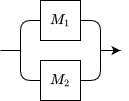

In [5]:
source = Source() # by default, machines pulling from source are never starved

M1 = Machine(name='M1', cycle_time=1)
M2 = Machine(name='M2', cycle_time=1)

sink = Sink()

objects = [source, M1, M2, sink]

M1.define_routing(upstream=[source], downstream=[sink])
M2.define_routing(upstream=[source], downstream=[sink])

system = System(objects=objects)


system.simulate(simulation_time=100)

print(f'\nM1 parts made: {M1.parts_made}')
print(f'M2 parts made: {M2.parts_made}')

Simulation finished in 0.00s
Parts produced: 200

M1 parts made: 100
M2 parts made: 100


### Parallel stations
<!--- $\rightarrow [M_1, M_2] \rightarrow B_1 \rightarrow [M_3, M_4, M_5] \rightarrow B_2 \rightarrow [M_6, M_7] \rightarrow$ -->

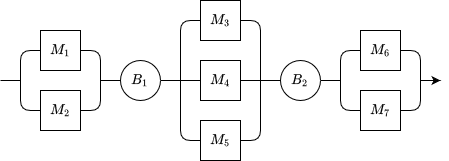

In [6]:
source = Source()

M1 = Machine('M1', cycle_time=2)
M2 = Machine('M2', cycle_time=2)

station1 = [M1, M2]

B1 = Buffer(capacity=10)

M3 = Machine('M3', cycle_time=3)
M4 = Machine('M4', cycle_time=3)
M5 = Machine('M5', cycle_time=3)

station2 = [M3, M4, M5]

B2 = Buffer(capacity=10)

M6 = Machine('M7', cycle_time=2)
M7 = Machine('M6', cycle_time=2)

station3 = [M6, M7]

sink = Sink()

M1.define_routing(upstream=[source], downstream=[B1])
M2.define_routing(upstream=[source], downstream=[B1])

M3.define_routing(upstream=[B1], downstream=[B2])
M4.define_routing(upstream=[B1], downstream=[B2])
M5.define_routing(upstream=[B1], downstream=[B2])

M6.define_routing(upstream=[B2], downstream=[sink])
M7.define_routing(upstream=[B2], downstream=[sink])

objects = [source] + station1 + [B1] + station2 + [B2] + station3 + [sink]

system = System(objects=objects)

system.simulate(simulation_time=100)

print(f'\nM1 parts made: {M1.parts_made}')
print(f'M2 parts made: {M2.parts_made}')
print(f'Station 1 parts made: {M1.parts_made + M2.parts_made}\n')

print(f'M3 parts made: {M3.parts_made}')
print(f'M4 parts made: {M4.parts_made}')
print(f'M5 parts made: {M5.parts_made}')
print(f'Station 2 parts made: {M3.parts_made + M4.parts_made + M5.parts_made}\n')

print(f'M1 parts made: {M6.parts_made}')
print(f'M2 parts made: {M7.parts_made}')
print(f'Station 3 parts made: {M6.parts_made + M7.parts_made}\n')

print(f'Total parts made: {sink.level}')

Simulation finished in 0.00s
Parts produced: 94

M1 parts made: 50
M2 parts made: 50
Station 1 parts made: 100

M3 parts made: 32
M4 parts made: 32
M5 parts made: 32
Station 2 parts made: 96

M1 parts made: 47
M2 parts made: 47
Station 3 parts made: 94

Total parts made: 94


### Parallel lines
<!--- $\rightarrow [[M_1 \rightarrow B_1 \rightarrow M_2 \rightarrow B_2 \rightarrow M_3], [M_4 \rightarrow B_4 \rightarrow M5]] \rightarrow$ -->

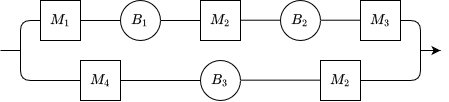

In [7]:
source = Source()

M1 = Machine('M1', cycle_time=1)
B1 = Buffer(capacity=10)
M2 = Machine('M2', cycle_time=1)
B2 = Buffer(capacity=10)
M3 = Machine('M3', cycle_time=1)

line1 = [M1, B1, M2, B2, M3]

M4 = Machine('M4', cycle_time=1)
B4 = Buffer(capacity=10)
M5 = Machine('M5', cycle_time=2)

line2 = [M4, B4, M5]

sink = Sink()

M1.define_routing(upstream=[source], downstream=[B1])
M2.define_routing(upstream=[B1], downstream=[B2])
M3.define_routing(upstream=[B2], downstream=[sink])

M4.define_routing(upstream=[source], downstream=[B4])
M5.define_routing(upstream=[B4], downstream=[sink])

objects = [source] + line1 + line2 + [sink]

system = System(objects=objects)

system.simulate(simulation_time=100)

print()

print(f'M1 parts made: {M1.parts_made}')
print(f'M2 parts made: {M2.parts_made}')
print(f'M3 parts made: {M3.parts_made}')
print(f'Line 1 parts made: {M3.parts_made}\n')

print(f'M4 parts made: {M4.parts_made}')
print(f'M5 parts made: {M5.parts_made}')
print(f'Line 2 parts made: {M5.parts_made}\n')

print(f'Total parts made: {sink.level}')

Simulation finished in 0.01s
Parts produced: 147

M1 parts made: 100
M2 parts made: 99
M3 parts made: 98
Line 1 parts made: 98

M4 parts made: 60
M5 parts made: 49
Line 2 parts made: 49

Total parts made: 147


### Complex configuration

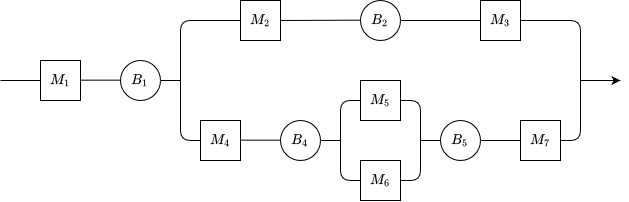

In [8]:
source = Source()

M1 = Machine('M1', cycle_time=1)
B1 = Buffer(capacity=10)

M2 = Machine('M2', cycle_time=3)
B2 = Buffer(capacity=5)
M3 = Machine('M3', cycle_time=2)

M4 = Machine('M4', cycle_time=1)
B4 = Buffer(capacity=5)
M5 = Machine('M5', cycle_time=2)
M6 = Machine('M6', cycle_time=2)
B5 = Buffer(capacity=5)
M7 = Machine('M7', cycle_time=3)

sink = Sink()

M1.define_routing(upstream=[source], downstream=[B1])

M2.define_routing(upstream=[B1], downstream=[B2])
M3.define_routing(upstream=[B2], downstream=[sink])

M4.define_routing(upstream=[B1], downstream=[B4])
M5.define_routing(upstream=[B4], downstream=[B5])
M6.define_routing(upstream=[B4], downstream=[B5])
M7.define_routing(upstream=[B5], downstream=[sink])

objects = [source, M1, M2, M3, M4, M5, M6, M7, B1, B2, B4, B5, sink]

system = System(objects=objects)

system.simulate(simulation_time=100)

print()
for obj in objects:
    if type(obj) == Machine:
        print(f'{obj.name} parts made: {obj.parts_made}')

print(f'\nTotal parts made: {sink.level}')

Simulation finished in 0.01s
Parts produced: 63

M1 parts made: 87
M2 parts made: 33
M3 parts made: 32
M4 parts made: 44
M5 parts made: 5
M6 parts made: 32
M7 parts made: 31

Total parts made: 63


### Single machine with degradation

For degradation rate $p=0.1$,

$
\mathbf{Q}=
\begin{bmatrix}
0.9 & 0.1 & 0 & 0 & 0 \\
0 & 0.9 & 0.1 & 0 & 0 \\
0 & 0 & 0.9 & 0.1 & 0 \\
0 & 0 & 0 & 0.9 & 0.1 \\
0 & 0 & 0 & 0 & 1
\end{bmatrix}
$

Calculating availability:

$MTTF=(1/p)*h_\max=(1/0.1)*4=40$

$MTTR=(a+b)/2=(20+30)/2=25$

$A = MTTF / (MTTF + MTTR) = 0.6154$

Expected steady-state production rate:

$r_e=(1/t_i) \times A = 0.6154~\textrm{parts/time}$

In [11]:
#random.seed(1)

p = 0.1
h_max = 10
degradation_matrix = utils.generate_degradation_matrix(p=p, h_max=h_max)

a, b = [20,30]
cm_distribution = {'uniform': [a, b]}

source = Source()
M1 = Machine(
    name='M1', 
    cycle_time=1,
    degradation_matrix=degradation_matrix,
    cm_distribution=cm_distribution
)
sink = Sink()

objects = [source, M1, sink]

M1.define_routing(upstream=[source], downstream=[sink])

system = System(objects=objects)

system.simulate(simulation_time=1000000)

Simulation finished in 21.67s
Parts produced: 800468


In [12]:
f'{1 - (M1.downtime / system.env.now):.2%}'

'80.05%'

In [10]:
mttf = (1 / p) * (len(degradation_matrix) - 1)
mttr = (a + b) / 2
availability = mttf / (mttf + mttr)

print(f'Expected availability: {availability:.2%}')

r_e = availability * (1 / M1.cycle_time)

print(f'Expected effective production rate: {r_e:.4f} units/time')

Expected availability: 80.00%
Expected effective production rate: 0.8000 units/time


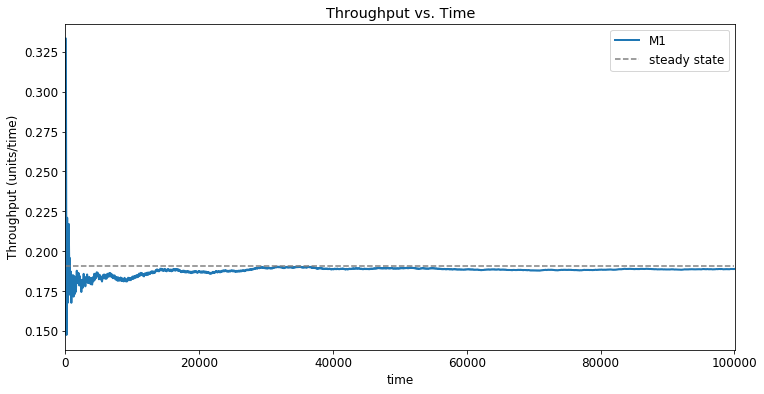

In [15]:
plt.figure(figsize=(12,6))

m1_production = pd.DataFrame(M1.production_data)
m2_production = pd.DataFrame(M2.production_data)

m1_throughput = m1_production['production'] / m1_production['time']

plt.plot(m1_production['time'], m1_throughput, label='M1', lw=2)

plt.plot(
    [0, system.env.now], [r_e]*2, linestyle='--', color='gray', label='steady state'
)

plt.title('Throughput vs. Time')
plt.xlabel('time')
plt.ylabel('Throughput (units/time)')

#plt.ylim([0, M1.cycle_time])
plt.xlim([0, system.env.now+100])

plt.legend()

plt.show()

### 2 machine 1 buffer line with degradation

In [12]:
random.seed(2)

degradation_matrix = generate_degradation_matrix(p=0.1, h_max=10)

cm_distribution = {'uniform': [20, 30]}

source = Source()
M1 = Machine(
    name='M1', 
    cycle_time=5,
    degradation_matrix=degradation_matrix,
    cm_distribution=cm_distribution
)
B1 = Buffer(capacity=5)
M2 = Machine(
    name='M2', 
    cycle_time=1,
    degradation_matrix=degradation_matrix,
    cm_distribution=cm_distribution
)
sink = Sink()

objects = [source, M1, B1, M2, sink]

M1.define_routing(upstream=[source], downstream=[B1])
M2.define_routing(upstream=[B1], downstream=[sink])

system = System(objects=objects)

system.simulate(simulation_time=100, debug=True)



 --------------- t=0 ---------------


Events at t=0:
  M1 get_part
  M2 get_part

Future events list:
  1 M1 degrade
  1 M2 degrade
  100 Environment terminate

M1 getting part at t=0


 --------------- t=1 ---------------


Events at t=1:
  M1 degrade
  M2 degrade
  M2 get_part

Future events list:
  5 M1 put_part
  100 Environment terminate

M1 degrading at t=1, health=1
M2 degrading at t=1, health=1


 --------------- t=2 ---------------


Events at t=2:
  M2 get_part

Future events list:
  5 M1 put_part
  7 M2 degrade
  11 M1 degrade
  100 Environment terminate



 --------------- t=3 ---------------


Events at t=3:
  M2 get_part

Future events list:
  5 M1 put_part
  7 M2 degrade
  11 M1 degrade
  100 Environment terminate



 --------------- t=4 ---------------


Events at t=4:
  M2 get_part

Future events list:
  5 M1 put_part
  7 M2 degrade
  11 M1 degrade
  100 Environment terminate



 --------------- t=5 ---------------


Events at t=5:
  M1 put_part
  M2 get_part

Futur

In [14]:
import matplotlib

In [15]:
matplotlib.__version__

'2.0.2'

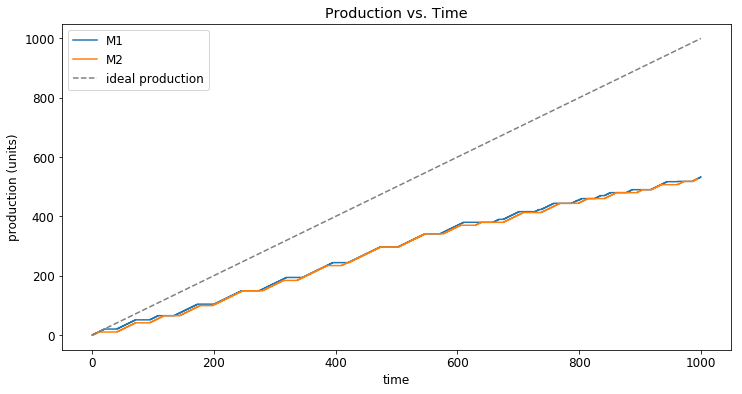

In [18]:
plt.figure(figsize=(12,6))

m1_production = pd.DataFrame(M1.production_data)
m2_production = pd.DataFrame(M2.production_data)

plt.step(m1_production['time'], m1_production['production'], where='post', label='M1')
plt.step(m2_production['time'], m2_production['production'], where='post', label='M2')

plt.plot([0, system.env.now], [0, system.env.now], linestyle='--', color='gray', label='ideal production')

plt.title('Production vs. Time')
plt.xlabel('time')
plt.ylabel('production (units)')

plt.legend()

plt.show()

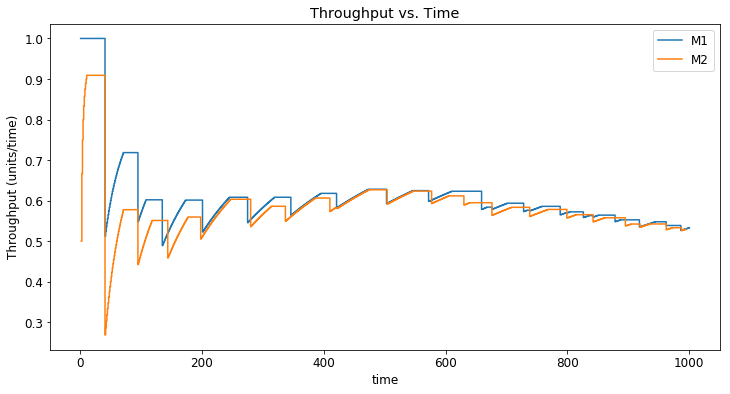

In [19]:
plt.figure(figsize=(12,6))

m1_production = pd.DataFrame(M1.production_data)
m2_production = pd.DataFrame(M2.production_data)

m1_throughput = m1_production['production'] / m1_production['time']
m2_throughput = m2_production['production'] / m2_production['time']

plt.step(m1_production['time'], m1_throughput, where='post', label='M1')
plt.step(m2_production['time'], m2_throughput, where='post', label='M2')

#plt.plot([0, system.env.now], [1, 1], linestyle='--', color='gray', label='ideal throughput')

plt.title('Throughput vs. Time')
plt.xlabel('time')
plt.ylabel('Throughput (units/time)')
plt.legend()

plt.show()

### 2 machine 1 buffer line with condition-based maintenance

In [20]:
random.seed(1)

degradation_matrix = generate_degradation_matrix(p=0.1, h_max=4)

cm_distribution = {'uniform': [20, 30]}
pm_distribution = {'uniform': [5, 10]}

source = Source()
M1 = Machine(
    name='M1', 
    cycle_time=1,
    degradation_matrix=degradation_matrix,
    cbm_threshold=3,
    pm_distribution=pm_distribution,
    cm_distribution=cm_distribution
)
B1 = Buffer(capacity=1)
M2 = Machine(
    name='M2', 
    cycle_time=1,
    degradation_matrix=degradation_matrix,
    cbm_threshold=3,
    pm_distribution=pm_distribution,
    cm_distribution=cm_distribution
)
sink = Sink()

objects = [source, M1, B1, M2, sink]

M1.define_routing(upstream=[source], downstream=[B1])
M2.define_routing(upstream=[B1], downstream=[sink])

repairman = Repairman(capacity=1)

system = System(objects=objects, repairman=repairman)

system.simulate(simulation_time=500, debug=False)

Simulation finished in 0.02s
Parts produced: 271


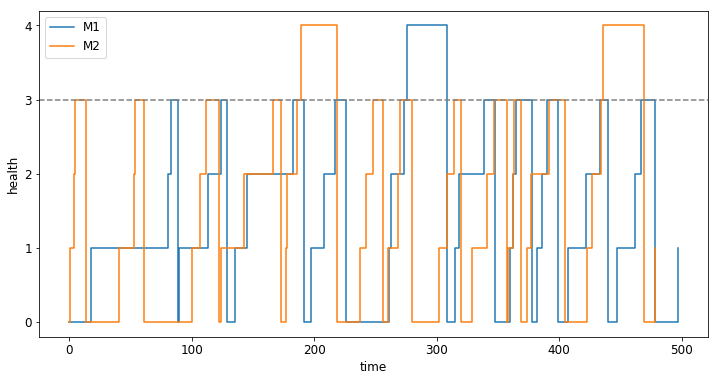

In [21]:
# plot health
m1_health = pd.DataFrame(M1.health_data)
m2_health = pd.DataFrame(M2.health_data)

plt.figure(figsize=(12,6))

plt.step(m1_health['time'], m1_health['health'], where='post', label='M1')
plt.step(m2_health['time'], m2_health['health'], where='post', label='M2')

plt.axhline(y=M1.cbm_threshold, color='gray', linestyle='--')

plt.yticks(range(5))

plt.xlabel('time')
plt.ylabel('health')

plt.legend(loc='upper left')

plt.show()

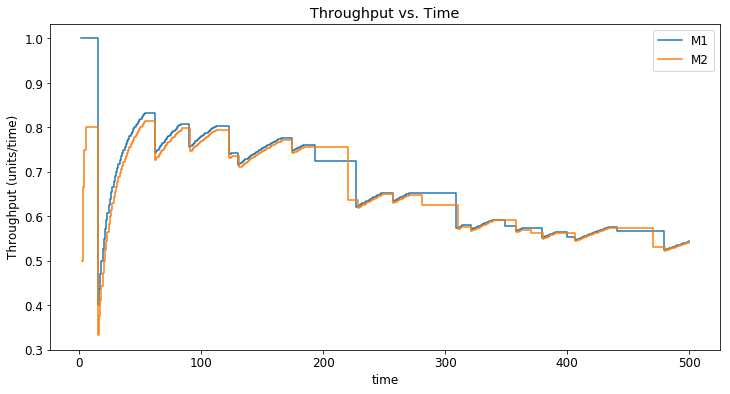

In [23]:
plt.figure(figsize=(12,6))

m1_production = pd.DataFrame(M1.production_data)
m2_production = pd.DataFrame(M2.production_data)

m1_throughput = m1_production['production'] / m1_production['time']
m2_throughput = m2_production['production'] / m2_production['time']

plt.step(m1_production['time'], m1_throughput, where='post', label='M1')
plt.step(m2_production['time'], m2_throughput, where='post', label='M2')

#mean_th = m1_throughput[4000:].mean()
#plt.plot([0, system.env.now], [mean_th, mean_th], linestyle='--', color='gray', label='ideal throughput')

plt.title('Throughput vs. Time')
plt.xlabel('time')
plt.ylabel('Throughput (units/time)')
plt.legend()

plt.show()

In [24]:
m1_maintenance = pd.DataFrame(M1.maintenance_data)[['time', 'event']]

m1_maintenance[
    (m1_maintenance['time'] >= 350)
    & (m1_maintenance['time'] <= 400)
]

,time,event
19,365,enter queue
20,369,begin maintenance
21,378,repaired
22,390,enter queue
23,390,begin maintenance
24,399,repaired


In [25]:
m2_maintenance = pd.DataFrame(M2.maintenance_data)[['time', 'event']]

m2_maintenance[
    (m2_maintenance['time'] >= 350)
    & (m2_maintenance['time'] <= 400)
]

,time,event
27,357,repaired
28,363,enter queue
29,363,begin maintenance
30,369,repaired
31,392,enter queue
32,399,begin maintenance


### CBM optimization: 2 machine 1 buffer line

In [26]:
p = 0.1
h_max = 10

degradation_matrix = generate_degradation_matrix(p=p, h_max=h_max)

def sample_production(policy): # policy = [h_1, h_2]
    cm_distribution = {'uniform': [20, 40]}
    pm_distribution = {'uniform': [5, 10]}

    source = Source()
    M1 = Machine(
        name='M1', 
        cycle_time=1,
        degradation_matrix=degradation_matrix,
        cbm_threshold=policy[0],
        pm_distribution=pm_distribution,
        cm_distribution=cm_distribution
    )
    B1 = Buffer(capacity=10)
    M2 = Machine(
        name='M2', 
        cycle_time=1,
        degradation_matrix=degradation_matrix,
        cbm_threshold=policy[1],
        pm_distribution=pm_distribution,
        cm_distribution=cm_distribution
    )
    sink = Sink()

    objects = [source, M1, B1, M2, sink]

    M1.define_routing(upstream=[source], downstream=[B1])
    M2.define_routing(upstream=[B1], downstream=[sink])

    repairman = Repairman(capacity=1)

    system = System(objects=objects, repairman=repairman)
    
    system.simulate(simulation_time=1440, verbose=False)
    
    return sink.level

In [27]:
random.seed(1)

n = 100

if False:
    results = pd.DataFrame(columns=['h_1', 'h_2', 'production'])

    start = time.time()
    for h_1 in range(1, h_max+1):
        for h_2 in range(1, h_max+1):
            samples = []
            for _ in range(n):
                samples.append(sample_production([h_1, h_2]))
            avg = sum(samples) / n
            new = pd.DataFrame({'h_1':[h_1], 'h_2':h_2, 'production':avg})
            results = results.append(new, ignore_index=True)
    stop = time.time()
    print(f'Finished in {stop-start:.2f}s')

    results.to_csv('cbm_opt_example.csv')
else:
    results = pd.read_csv('cbm_opt_example.csv', index_col=0)

In [28]:
results.head(10)

,h_1,h_2,production
0,1,1,603.43
1,1,2,731.38
2,1,3,763.00
3,1,4,782.90
4,1,5,791.00
5,1,6,796.96
6,1,7,792.07
7,1,8,753.90
8,1,9,686.85
9,1,10,653.10


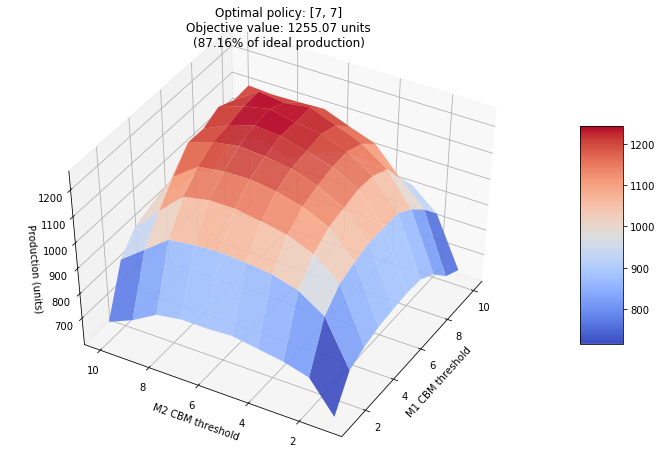

In [29]:
plt.rcParams.update({'font.size': 10})

fig = plt.figure(figsize=(12,8))
ax = fig.gca(projection='3d')

x, y = np.meshgrid(range(1,h_max+1), range(1,h_max+1))

surface = ax.plot_surface(
    x,
    y,
    results['production'].values.reshape((h_max, h_max)),
    cmap=cm.coolwarm,
    alpha=0.9
)

fig.colorbar(surface, shrink=0.5, aspect=5)

optimal_policy = results['production'].argmax()
m1_optimal = results.loc[optimal_policy, 'h_1']
m2_optimal = results.loc[optimal_policy, 'h_2']
production_optimal = results.loc[optimal_policy, 'production']

title = (
    f'Optimal policy: [{m1_optimal}, {m2_optimal}]'
    + f'\nObjective value: {production_optimal} units'
    + f'\n({production_optimal/1440:.2%} of ideal production)'
)
ax.set_title(title)
ax.set_xlabel('M1 CBM threshold')
ax.set_ylabel('M2 CBM threshold')
ax.set_zlabel('Production (units)')

ax.view_init(45, 210)

plt.show()

### Complex system with CBM

In [3]:
Q = generate_degradation_matrix(p=0.1, h_max=10)

cm = {'uniform': [20, 30]}
pm = {'uniform': [5, 10]}

source = Source()

M1 = Machine('M1', cycle_time=1, degradation_matrix=Q)
B1 = Buffer(capacity=10)

M2 = Machine('M2', cycle_time=3, degradation_matrix=Q)
B2 = Buffer(capacity=5)
M3 = Machine('M3', cycle_time=2, degradation_matrix=Q)

M4 = Machine('M4', cycle_time=1, degradation_matrix=Q)
B4 = Buffer(capacity=5)
M5 = Machine('M5', cycle_time=2, degradation_matrix=Q)
M6 = Machine('M6', cycle_time=2, degradation_matrix=Q)
B5 = Buffer(capacity=5)
M7 = Machine('M7', cycle_time=3, degradation_matrix=Q)

B6 = Buffer(capacity=10)
M8 = Machine('M8', cycle_time=1, degradation_matrix=Q)

sink = Sink()

M1.define_routing(upstream=[source], downstream=[B1])

M2.define_routing(upstream=[B1], downstream=[B2])
M3.define_routing(upstream=[B2], downstream=[B6])

M4.define_routing(upstream=[B1], downstream=[B4])
M5.define_routing(upstream=[B4], downstream=[B5])
M6.define_routing(upstream=[B4], downstream=[B5])
M7.define_routing(upstream=[B5], downstream=[B6])

M8.define_routing(upstream=[B6], downstream=[sink])

for machine in [M1, M2, M3, M4, M5, M6, M7, M8]:
    machine.pm_distribution = pm
    machine.cm_distribution = cm

objects = [source, M1, M2, M3, M4, M5, M6, M7, M8, B1, B2, B4, B5, B6, sink]

#repairman = Repairman(capacity=2)

system = System(objects=objects)#, repairman=repairman)

system.simulate(simulation_time=10000)

print()
for obj in objects:
    if type(obj) == Machine:
        print(f'{obj.name} parts made: {obj.parts_made}')

print(f'\nTotal parts made: {sink.level}')

Simulation finished in 0.91s
Parts produced: 4685

M1 parts made: 5062
M2 parts made: 2284
M3 parts made: 2235
M4 parts made: 2657
M5 parts made: 1331
M6 parts made: 1198
M7 parts made: 2470
M8 parts made: 4685

Total parts made: 4685


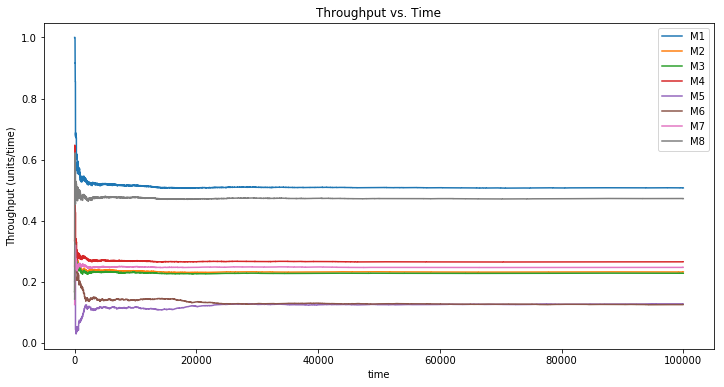

In [31]:
plt.figure(figsize=(12,6))

for i, machine in enumerate(system.machines):
    production = pd.DataFrame(machine.production_data)
    throughput = production['production'] / production['time']
    
    plt.step(production['time'], throughput, where='post', label=f'M{i+1}')

plt.title('Throughput vs. Time')
plt.xlabel('time')
plt.ylabel('Throughput (units/time)')
plt.legend()

plt.show()

In [5]:
# serial 
_ = system.iterate_simulation(50, 1440, 1440, jobs=1)
print()

# parallel
_ = system.iterate_simulation(50, 1440, 1440, jobs=12)

Finished 50 replications in 13.31s
Average production: 675.28 units

Finished 50 replications in 4.51s
Average production: 678.18 units
